## **3. Risk analysis & stress testing**

**OVERVIEW**

This section introduces the first components of the portfolio’s risk profile. The objective is to understand how the portfolio behaves under adverse conditions and to quantify the characteristics of its equity curve.

Specifically, this step will:
- Reconstruct and analyse the portfolio’s equity curve.
- Quantify drawdowns, their duration and recovery patterns.
- Study rolling volatility over different horizons (30 / 60 / 90 days).
- Compute daily risk metrics such as historical and parametric VaR.
- Estimate tail risk via CVaR / Expected Shortfall.
- Measure the probability of loss over different loss thresholds.
- Assess the portfolio’s behaviour relative to a market benchmark (beta and correlation).
- Perform hypothetical and historical stress tests on the portfolio.
- Summarise the overall risk profile in a concise, decision-oriented set of insights.

**SUMMARY RESULTS**

- The drawdown analysis shows that the portfolio typically spends around **10 days** under water with an average maximum loss of roughly **–1.5%** per drawdown episode.
- However, it has also experienced a **very extended drawdown of 310 days** and a **deep peak-to-trough loss of about –24% during early 2020**, which sets the baseline for the more detailed risk and stress-testing work that follows in this phase.
- Annualised volatility fluctuates between **~8–15%** during most periods, with a sharp spike above **30–50%** during the **early-2020 market turmoil**, after which volatility gradually stabilises across all rolling windows (30d, 60d, 90d), exhibiting a smoother profile at longer horizons.
- **VaR** and **CVaR** analyses reveal a non-linear increase in tail risk across both confidence levels and time horizons, with **10-day 99% CVaR** reaching **~12%** of portfolio value (**~£12k**), while Student-t estimates consistently capture heavier tails and align more closely with historical extreme losses than the Normal model.

#### **3.1 Importing necessary libraries**

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from src.helpers_io import read_csv_processed

#### **3.2 Loading `asset_universe.csv`**

In [8]:
# Loading processed data
processed_data = read_csv_processed("asset_universe.csv", parse_dates=["Date"]).set_index("Date").sort_index()

# Splitting risk-free rate (IRX) from the asset universe
annual_risk_free = processed_data["IRX"]
asset_universe = processed_data.drop(columns=["IRX"])

#### **3.3 Data cleaning and calculations**

In [9]:
# Computing log and simple returns for further analysis
log_returns = pd.DataFrame(np.log(asset_universe / asset_universe.shift(1))).replace([np.inf, -np.inf], np.nan).dropna()
simple_returns = ((asset_universe / asset_universe.shift(1)) - 1).dropna().reindex(index=log_returns.index)

# Calculating weights
weights = pd.Series(1 / len(asset_universe.columns), index= asset_universe.columns, name="equal_weights")

# Portfolio returns
log_port_returns = (log_returns * weights).sum(axis=1).rename("log_port_returns")
simple_port_returns = (simple_returns * weights).sum(axis=1).rename("simple_port_returns")

# Cumulative capital over 2019-2024
initial_capital = 100_000
equity_curve = (initial_capital * (1 + simple_port_returns).cumprod()).rename("equity_curve")

# Daily drawdown (%)
rolling_peak = equity_curve.cummax()
daily_drawdown = ((equity_curve / rolling_peak) - 1).rename("daily_drawdown")

# Daily risk-free rate
rf_aligned = annual_risk_free.reindex(index=log_port_returns.index).ffill()
trading_days = 252  # Typical trading days in a year
daily_rf = ((1 + (rf_aligned / 100)) ** (1 / trading_days) - 1).rename("daily_rf")

# Concatenating data
risk_data = pd.concat([log_port_returns, simple_port_returns, equity_curve, daily_drawdown, daily_rf], axis=1)

c:\Users\james\Desktop\UK Life\Data Scientist Career Path\My notes (Python, SQL, etc.)\Portfolio of projects\finance-project\env\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


#### **3.4 Drawdown insights**

In this subsection, the focus is on how the portfolio behaves once it falls below its previous peak. The starting point is the equity curve, from which daily drawdowns are computed as:

$$
DD_t = \frac{E_t}{\max_{i \le t} E_i} - 1,
$$

where $E_t$ is the portfolio equity at time $t$ and $\max_{i \leq t} E_i$ is the running peak up to that date.

A drawdown episode is defined as any continuous period where $DD_t < 0$. These episodes are then grouped and summarised by:

- Start and end dates of each drawdown.
- Number of days spent under water (episode duration).
- Maximum depth within the episode (worst point of the drawdown).

This structure provides a clear view of how often the portfolio enters drawdown, how long it tends to stay there, and how severe those episodes typically are, forming the first building block of the broader risk analysis in this phase.

In [10]:
# Creating a function for scalability
def drawdown_insights(df: pd.DataFrame) -> pd.DataFrame:

    # Creating boolean mask to detect when a drawdown happens
    bool_mask = df["daily_drawdown"] < 0

    # Detecting all blocks where there were a drawdown (%)
    dd_blocks = (bool_mask != bool_mask.shift()).cumsum().where(bool_mask)

    # Adding IDs to each block
    temp_df = df[["daily_drawdown"]].copy()
    temp_df["block_id"] = dd_blocks
    temp_df = temp_df.dropna()

    # Grouping data by 'block_id'
    dd_summary = (
        temp_df
        .groupby("block_id")
        .agg(
            start=("daily_drawdown", lambda x: x.index.min()),
            end=("daily_drawdown", lambda x: x.index.max()),
            duration_days=("daily_drawdown", "size"),
            max_drawdown=("daily_drawdown", "min")
        )
    )

    return dd_summary.sort_values(by="max_drawdown", ascending=True)

# Drawdown insights
drawdown_summary = drawdown_insights(risk_data)

longest_dd_block = drawdown_summary["duration_days"].idxmax()   # Longest drawdown (by duration)
worst_dd_block = drawdown_summary["max_drawdown"].idxmin()  # Deepest drawdown (by magnitude)
average_duration = drawdown_summary["duration_days"].mean()
average_drawdown = drawdown_summary["max_drawdown"].mean()

# Results
results = drawdown_summary.loc[[longest_dd_block, worst_dd_block]].T
results.columns = ["longest_drawdown", "max_drawdown_global"]

print(f"""Drawdown insights

Average DD duration: {average_duration:.0f} days
Average DD: {average_drawdown:.2%}""")

display(results)

Drawdown insights

Average DD duration: 10 days
Average DD: -1.52%


,longest_drawdown,max_drawdown_global
start,2022-03-31 00:00:00,2020-02-20 00:00:00
end,2023-07-11 00:00:00,2020-05-14 00:00:00
duration_days,310,56
max_drawdown,-0.18129,-0.238277


#### **3.5 Rolling volatility**

This subsection examines how the portfolio’s risk level evolves over time by computing annualised volatility using rolling windows of different lengths:

- **30-day window** → short-term sensitivity to recent shocks  
- **60-day window** → medium-term risk profile  
- **90-day window** → smoother, structural view of volatility  

Tracking these rolling measures helps identify periods where risk rises sharply, assess whether volatility spikes align with major market events (e.g., early-2020 turmoil), and evaluate how quickly the portfolio transitions between calm and stressed regimes. This provides a dynamic, time-aware picture of portfolio risk that complements the static metrics calculated later in the analysis.

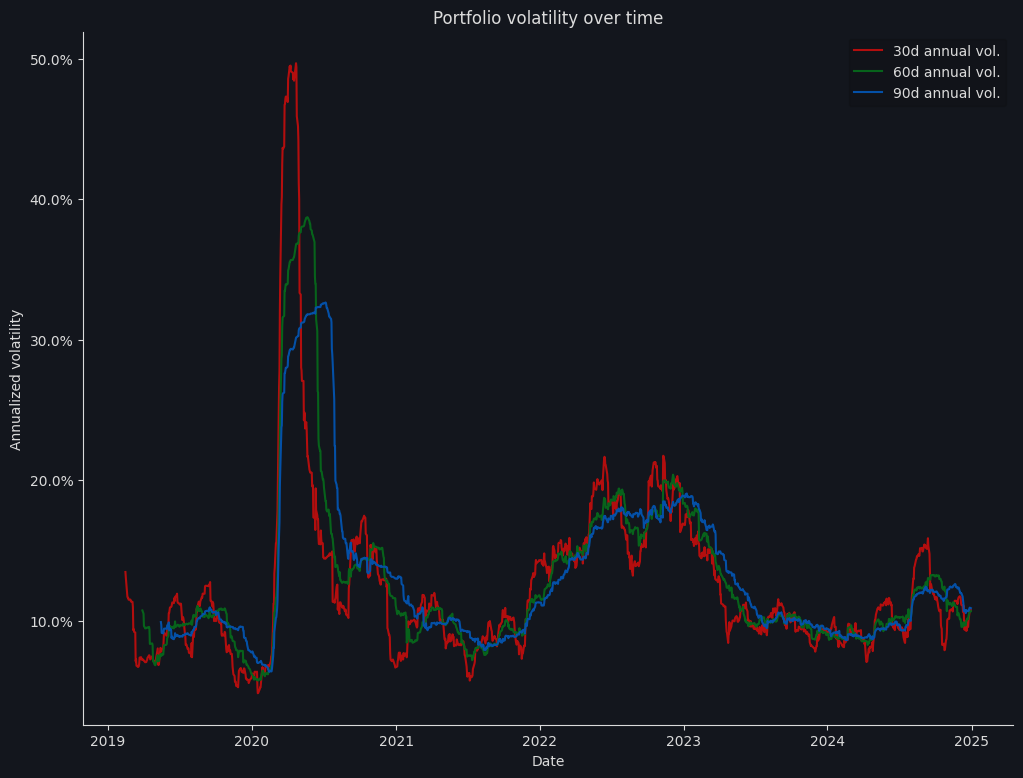

In [11]:
# Computing annual rolling volatility (30d, 60d, 90d)
vol_30d_ann = log_port_returns.rolling(window=30).std() * np.sqrt(trading_days)
vol_60d_ann = log_port_returns.rolling(window=60).std() * np.sqrt(trading_days)
vol_90d_ann = log_port_returns.rolling(window=90).std() * np.sqrt(trading_days)

# Storing data into 'risk_data'
risk_data["vol_30d_ann"] = vol_30d_ann
risk_data["vol_60d_ann"] = vol_60d_ann
risk_data["vol_90d_ann"] = vol_90d_ann

# Creating main subplots
fig, ax = plt.subplots(figsize=(12, 9))

# Customizing layout
background_color = "#13161D"
font_color = "#dbdbdb"

fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.tick_params(axis="both", which="both", colors=font_color)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color(font_color)

# Adding volatility data to the axes
ax.plot(vol_30d_ann.index, vol_30d_ann, color="#B30E0E", label="30d annual vol.")
ax.plot(vol_60d_ann.index, vol_60d_ann, color="#07631B", label="60d annual vol.")
ax.plot(vol_90d_ann.index, vol_90d_ann, color="#0450A7", label="90d annual vol.")

# Formatting y-axis as percentages (%)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# Setting labels
ax.set_xlabel("Date", color=font_color)
ax.set_ylabel("Annualized volatility", color=font_color)
ax.set_title("Portfolio volatility over time", color=font_color)

# Setting a legend
legend = ax.legend(loc="upper right", facecolor="#0E1014", edgecolor="#0F1011", labelcolor=font_color)
legend.get_frame().set_alpha(0.4)

# Plotting the chart
plt.show()

#### **3.6 Value at Risk (VaR) & Conditional Value at Risk (CVaR)**

**Value at Risk (VaR)** estimates the maximum expected portfolio loss over a given time horizon and confidence level, while **Conditional VaR (CVaR)** measures the average loss beyond the VaR threshold, providing a more informative view of extreme tail risk.
- VaR and CVaR are computed using both **historical** and **parametric** approaches: the historical method captures empirical tail behaviour without distributional assumptions, while parametric Normal and Student-t models allow comparison under light- and heavy-tailed assumptions.
- Results show a clear increase in tail risk with longer horizons and higher confidence levels, with **CVaR consistently exceeding VaR**, as expected for asymmetric loss distributions.
- **Student-t estimates align more closely with historical tail risk**, especially at higher confidence levels and longer horizons, while Normal VaR/CVaR tends to underestimate extreme losses.

In [12]:
# Building loss series
portfolio_losses = (-log_port_returns).replace([np.inf, -np.inf], np.nan).dropna()

# Defining confidence levels and VaR horizon (in days)
confidence_levels = [0.95, 0.99]
time_horizons = [1, 5, 10]  # N-days VaR

# Creating functions for reusability
def historical_VaR(losses: pd.Series, alpha: float = 0.95) -> float:
    """This function computes historical VaR for a loss series"""

    if not (0 < alpha < 1):
        raise ValueError("alpha must be in (0, 1). Example: 0.99")

    return losses.quantile(alpha)    # VaR

def historical_CVaR(losses: pd.Series, alpha: float = 0.95) -> float:
    """This function computes historical Conditional VaR for a loss series"""

    if not (0 < alpha < 1):
        raise ValueError("alpha must be in (0, 1). Example: 0.99")

    var = losses.quantile(alpha)
    return losses[losses >= var].mean()     # CVaR

def parametric_VaR(params: dict, alpha: float = 0.95, distribution: str="Normal") -> float:
    """This function computes the parametric VaR given a type of distribution"""

    if not (0 < alpha < 1):
        raise ValueError("alpha must be in (0, 1). Example: 0.99")

    # Calculating VaR based on distribution type
    dist = distribution.strip().lower()

    if dist in {"normal", "gaussian"}:
        mean_port = params["mean_port"]
        std_port = params["std_port"]

        if std_port <= 0:
            raise ValueError("Normal VaR requires portfolio standard deviation > 0")
        
        z_score = norm.ppf(alpha)
        return float(mean_port + (z_score * std_port))

    elif dist in {"t", "student-t", "t-distribution", "studentt"}:
        dof = params["dof"]
        loc = params["loc"]
        scale = params["scale"]

        if scale <= 0:
            raise ValueError("Student-t scale must be positive")

        return float(t.ppf(alpha, dof, loc=loc, scale=scale))

    else:
        raise ValueError("Expected distribution to be 'Normal' or 't-distribution'")

def parametric_CVaR(params: dict, alpha: float = 0.95, distribution: str="Normal") -> float:
    """This function computes the parametric Conditional VaR given a type of distribution"""

    if not (0 < alpha < 1):
        raise ValueError("alpha must be in (0, 1). Example: 0.99")

    # Calculating VaR based on distribution type
    dist = distribution.strip().lower()

    if dist in {"normal", "gaussian"}:
        mean_port = params["mean_port"]
        std_port = params["std_port"]

        if std_port <= 0:
            raise ValueError("Normal Conditional VaR requires portfolio standard deviation > 0")

        z_score = norm.ppf(alpha)
        pdf_z = norm.pdf(z_score)
        cvar = float(mean_port + (std_port * (pdf_z / (1 - alpha))))
        return cvar

    elif dist in {"t", "student-t", "t-distribution", "studentt"}:
        dof, loc, scale = params["dof"], params["loc"], params["scale"]

        if scale <= 0:
            raise ValueError("Student-t scale must be positive")
        if dof <= 1:
            raise ValueError("Student-t CVaR requires dof > 1")

        q = t.ppf(alpha, dof)
        pdf_q = t.pdf(q, dof)
        cvar = float(loc + scale * ((dof + q**2) / ((dof - 1) * (1 - alpha))) * pdf_q)
        return cvar

    else:
        raise ValueError("Expected distribution to be 'Normal' or 't-distribution'")

def summary_table(initial_capital: float, losses: pd.Series, confidence_levels: list[float], x_days: list[int]) -> pd.DataFrame:
    """This function creates a summary table of historical and parametric VaR and CVaR"""
    
    records = []

    for x_day in x_days:
        if x_day < 1:
            raise ValueError("Time horizon must be >= 1")
        
        # X-day aggregated losses
        losses_x_days = losses.rolling(x_day).sum().dropna()

        # Normal params (once per horizon)
        mean_port = float(losses_x_days.mean())
        std_port = float(losses_x_days.std(ddof=1))

        # Student-t params (once per horizon)
        dof, loc, scale = t.fit(losses_x_days.to_numpy(dtype=float))
        dof = float(dof); loc = float(loc); scale = float(scale)
        normal_params = {"mean_port": mean_port,"std_port":std_port}
        t_params = {"dof": dof, "loc":loc, "scale": scale}

        for cl in confidence_levels:
            # Historical X-day VaR and CVaR
            h_var = historical_VaR(losses_x_days, alpha=cl)
            h_cvar = historical_CVaR(losses_x_days, alpha=cl)
            h_simple_var = (1 - np.exp(-h_var))
            h_simple_cvar = (1 - np.exp(-h_cvar))
            h_var_cash = round(initial_capital * h_simple_var, 2)
            h_cvar_cash = round(initial_capital * h_simple_cvar, 2)

            # Parametric X-day VaR and CVaR
            norm_var = parametric_VaR(normal_params, alpha=cl, distribution="Normal")
            norm_cvar = parametric_CVaR(normal_params, alpha=cl, distribution="Normal")
            t_var = parametric_VaR(t_params, alpha=cl, distribution="student-t")
            t_cvar = parametric_CVaR(t_params, alpha=cl, distribution="student-t")
            norm_simple_var = (1 - np.exp(-norm_var))
            norm_simple_cvar = (1 - np.exp(-norm_cvar))
            t_simple_var = (1 - np.exp(-t_var))
            t_simple_cvar = (1 - np.exp(-t_cvar))
            norm_var_cash = round(initial_capital * norm_simple_var, 2)
            norm_cvar_cash = round(initial_capital * norm_simple_cvar, 2)
            t_var_cash = round(initial_capital * t_simple_var, 2)
            t_cvar_cash = round(initial_capital * t_simple_cvar, 2)

            records.append(
                {
                    "scenario": f"{x_day}d at {cl:.0%} confidence",
                    "time_horizon": x_day,
                    "confidence_level": cl,
                    "VaR_hist": h_simple_var,    # Simple historical VaR
                    "CVaR_hist": h_simple_cvar,  # Simple historical CVaR
                    "VaR_hist_cash": h_var_cash,
                    "CVaR_hist_cash": h_cvar_cash,
                    "VaR_norm": norm_simple_var,
                    "CVaR_norm": norm_simple_cvar,
                    "VaR_norm_cash": norm_var_cash,
                    "CVaR_norm_cash": norm_cvar_cash,
                    "VaR_t": t_simple_var,
                    "CVaR_t": t_simple_cvar,
                    "VaR_t_cash": t_var_cash,
                    "CVaR_t_cash": t_cvar_cash,
                }
            )

    summary = pd.DataFrame(records).set_index("scenario")

    return summary

# Summary results
results_var_cvar = summary_table(initial_capital, portfolio_losses, confidence_levels, time_horizons)
summary = round(results_var_cvar.copy(), 4)
display(summary)

,time_horizon,confidence_level,VaR_hist,CVaR_hist,VaR_hist_cash,CVaR_hist_cash,VaR_norm,CVaR_norm,VaR_norm_cash,CVaR_norm_cash,VaR_t,CVaR_t,VaR_t_cash,CVaR_t_cash
scenario,,,,,,,,,,,,,,
1d at 95% confidence,1,0.95,0.0131,0.0208,1314.53,2082.34,0.0139,0.0176,1394.87,1759.87,0.0123,0.0189,1230.32,1894.69
1d at 99% confidence,1,0.99,0.0211,0.0356,2108.64,3559.18,0.0199,0.0228,1989.46,2283.78,0.0223,0.0314,2228.32,3139.94
5d at 95% confidence,5,0.95,0.0299,0.0483,2987.79,4831.57,0.0300,0.0381,2997.61,3811.65,0.0261,0.0412,2607.69,4116.11
5d at 99% confidence,5,0.99,0.0557,0.0840,5574.35,8395.05,0.0432,0.0497,4321.73,4973.39,0.0487,0.0691,4866.81,6911.99
10d at 95% confidence,10,0.95,0.0400,0.0670,4001.67,6700.50,0.0411,0.0526,4114.24,5262.00,0.0346,0.0554,3463.61,5544.77
10d at 99% confidence,10,0.99,0.0738,0.1228,7375.03,12278.59,0.0598,0.0689,5979.06,6892.78,0.0658,0.0935,6581.28,9353.43
